# Creating a Classifier to Classify the type of Sport using Computer Vision

*by: Dipanshu Gupta.*

As part of exercise in FastAI course v3 by Jeremy Howard. Data set built using Google Images with inspiration from [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/).

`Note:` You probably need a GPU to run this program. I ran this on GCP (Google Cloud Platform). 

In [1]:
from fastai.vision import *

## Get a list of URLs

### Search and scroll

Go to [Google Images](http://images.google.com) and search for the images you are interested in. 

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling.

We can also limit our results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

### Download into file

Now we must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>J</kbd> in Mac, and a small window the javascript 'Console' will appear. This is where we will paste the JavaScript commands.

We need to get the urls of each of the images. You can do this by running the following commands:

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

### Create directory and upload URLs file into them. 

We create directories in our current directory for different sport and download images in them from the URLs we generated above. An appropriate name for the labeled images is chosen. 

In [2]:
path = Path('data/sports')

In [3]:
classes = ['badminton','baseball','basketball', 'cricket', 'football', 'golf', 'hockey', 'squash', 'swimming', 'tennis']

In [ ]:
def image_downloader(classes):
    for i in classes:
        folder = i  # A separate folder for the sport. 
        file = (i + '.csv') # .csv file that contains the list of URLs of the images. 
        dest = path/folder #Path to download images in. 
        dest.mkdir(parents=True, exist_ok=True)
        download_images(path/file, dest, max_pics=400) # command to download images. 
        download_images(path/file, dest, max_pics=20, max_workers=0) #To ensure there were no problems while downloading. 
    return;

In [ ]:
image_downloader(classes)

In [ ]:
path.ls()

Then we can remove any images that can't be opened:

In [10]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

badminton


baseball


basketball


This is not one of the allowed sizes of this image
cricket


football


golf


hockey


squash


swimming


tennis


## View data

In [12]:
#To randomise the data create a training set. 

np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [5]:
data.classes

['badminton',
 'baseball',
 'basketball',
 'cricket',
 'football',
 'golf',
 'hockey',
 'sports',
 'squash',
 'swimming',
 'tennis']

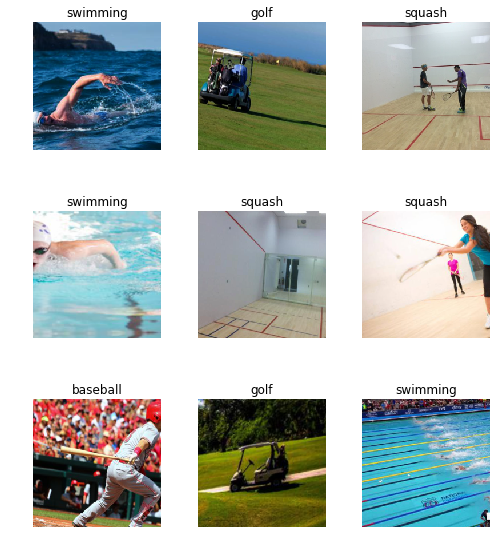

In [6]:
data.show_batch(rows=3, figsize=(7,8))

In [7]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['badminton',
  'baseball',
  'basketball',
  'cricket',
  'football',
  'golf',
  'hockey',
  'sports',
  'squash',
  'swimming',
  'tennis'],
 11,
 2996,
 749)

## Train model

I train a CNN resnet34 for this task. 

In [13]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [15]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
1,0.306461,0.307648,0.101604,00:16
2,0.313737,0.307382,0.110963,00:16
3,0.305314,0.284437,0.088235,00:16
4,0.249314,0.247425,0.078877,00:16
5,0.218493,0.243475,0.081551,00:16
6,0.188677,0.238559,0.080214,00:16


This looks pretty good for a first run. Let's save this model. 

In [23]:
learn.save('stage-1')

Time to see if Hyperparameter tuning would be useful for this problem. 

In [17]:
learn.unfreeze()

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


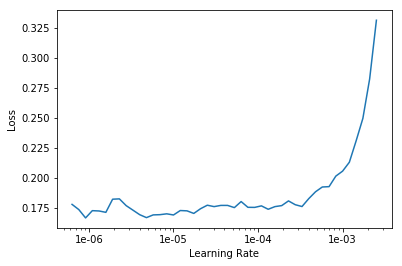

In [21]:
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(6, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
1,0.156565,0.240079,0.078877,00:20
2,0.162741,0.226664,0.076203,00:21
3,0.157345,0.221413,0.078877,00:21
4,0.139024,0.208595,0.070856,00:21
5,0.125667,0.215182,0.072193,00:21
6,0.125625,0.211405,0.077540,00:21


Looks pretty good. Let's save our model. 

In [24]:
learn.save('stage-2')

## Interpretation

In [25]:
learn.load('stage-2');

In [26]:
interp = ClassificationInterpretation.from_learner(learn)

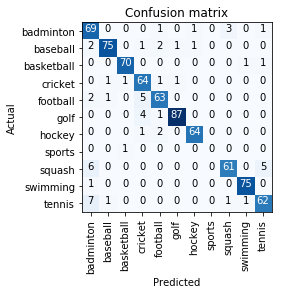

In [27]:
interp.plot_confusion_matrix()

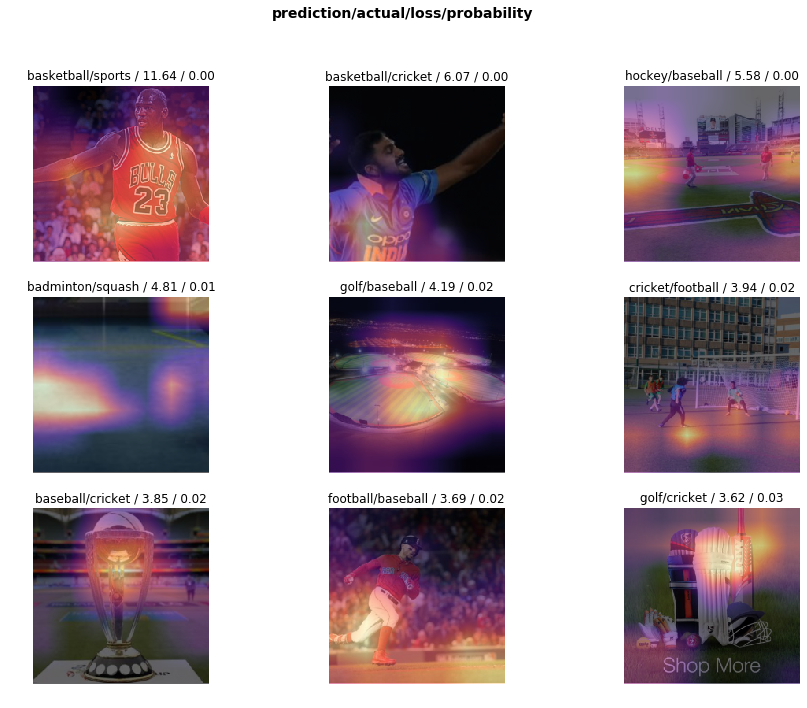

In [28]:
interp.plot_top_losses(9, figsize=(15,11))

Looks like our model fitted Grass layouts for golf and hard and shiny courts for squash. Seems pretty reasonable as we trained with less than 400 images only while traditional tasks are trained on milliond of images. Also, there was mislabelled image in the squash dataset which our classifier correctly identified. Win for us!

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

In [29]:
from fastai.widgets import *

First we need to get the file paths from our top_losses. We can do this with `.from_toplosses`. We then feed the top losses indexes and corresponding dataset to `ImageCleaner`.

Notice that the widget will not delete images directly from disk but it will create a new csv file `cleaned.csv` from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In [30]:
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)

In [31]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. `ImageCleaner` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses.ImageCleaner(ds, idxs)`

You can also find duplicates in your dataset and delete them! To do this, you need to run `.from_similars` to get the potential duplicates' ids and then run `ImageCleaner` with `duplicates=True`. The API works in a similar way as with misclassified images: just choose the ones you want to delete and click 'Next Batch' until there are no more images left.

In [32]:
ds, idxs = DatasetFormatter().from_similars(learn, ds_type=DatasetType.Valid)

Getting activations...


Computing similarities...


In [33]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Now, we load the cleaned data. 

In [34]:
np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:498: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
sports
  if getattr(ds, 'warn', False): warn(ds.warn)


## Putting the model in production

First thing first, let's export the content of our `Learner` object for production:

In [35]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

We revert back to using CPU for inference. 

In [36]:
defaults.device = torch.device('cpu')

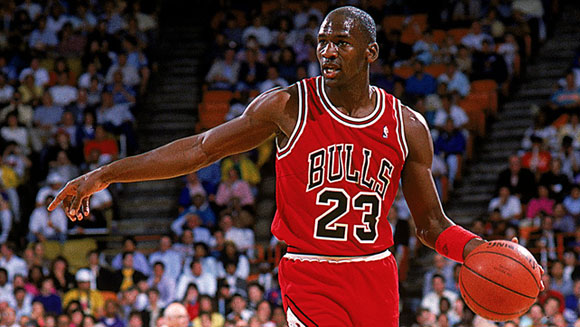

In [37]:
img = open_image(path/'jordan.jpg')
img

We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [38]:
learn = load_learner(path)

In [39]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class.obj

'basketball'

### Perfect! Looks like a classifier works well! So, here's my challenge. Find any image for the 10 sports classified here and my classifier will probably get this right more than 95% of the time. 